# Download and analyze data from OpenSteetMap using OSMnx

OSMnx –> Python for street networks. Retrieve, construct, analzyze, and visualize street networks from OpenStreetMap

Networkx –> Network analysis and routing in Python (e.g. Dijkstra and A* -algorithms)

In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd

import rtree
import itertools

from shapely.geometry import MultiPoint, LineString
from shapely.ops import snap, split

pd.options.mode.chained_assignment = None


def connect_poi(pois, nodes, edges, key_col=None, path=None, threshold=200, knn=5, meter_epsg=3857):
    """Connect and integrate a set of POIs into an existing road network.
    Given a road network in the form of two GeoDataFrames: nodes and edges,
    link each POI to the nearest edge (road segment) based on its projection
    point (PP) and generate a new integrated road network including the POIs,
    the projected points, and the connection edge.
    Args:
        pois (GeoDataFrame): a gdf of POI (geom: Point)
        nodes (GeoDataFrame): a gdf of road network nodes (geom: Point)
        edges (GeoDataFrame): a gdf of road network edges (geom: LineString)
        key_col (str): a unique key column of pois should be provided,
                       e.g., 'index', 'osmid', 'poi_number', etc.
                       Currently, this will be renamed into 'osmid' in the output.
                       [NOTE] For use in pandana, you may want to ensure this
                              column is numeric-only to avoid processing errors.
                              Preferably use unique integers (int or str) only,
                              and be aware not to intersect with the node key,
                              'osmid' if you use OSM data, in the nodes gdf.
        path (str): directory path to use for saving files (nodes and edges).
                      Outputs will NOT be saved if this arg is not specified.
        threshold (int): the max length of a POI connection edge, POIs with
                         connection edge beyond this length will be removed.
                         The unit is in meters as crs epsg is set to 3857 by
                         default during processing.
        knn (int): k nearest neighbors to query for the nearest edge.
                   Consider increasing this number up to 10 if the connection
                   output is slightly unreasonable. But higher knn number will
                   slow down the process.
        meter_epsg (int): preferred EPSG in meter units. Suggested 3857 or 3395.
    Returns:
        nodes (GeoDataFrame): the original gdf with POIs and PPs appended
        edges (GeoDataFrame): the original gdf with connection edges appended
                              and existing edges updated (if PPs are present)
    Note:
        1. Make sure all three input GeoDataFrames have defined crs attribute.
           Try something like `gdf.crs` or `gdf.crs = 'epsg:4326'`.
           They will then be converted into epsg:3857 or specified meter_epsg for processing.
    """

    ## STAGE 0: initialization
    # 0-1: helper functions
    def find_kne(point, lines):
        dists = np.array(list(map(lambda l: l.distance(point), lines)))
        kne_pos = dists.argsort()[0]
        kne = lines.iloc[[kne_pos]]
        kne_idx = kne.index[0]
        return kne_idx, kne.values[0]

    def get_pp(point, line):
        """Get the projected point (pp) of 'point' on 'line'."""
        # project new Point to be interpolated
        pp = line.interpolate(line.project(point))  # PP as a Point
        return pp

    def split_line(line, pps):
        """Split 'line' by all intersecting 'pps' (as multipoint).
        Returns:
            new_lines (list): a list of all line segments after the split
        """
        # IMPORTANT FIX for ensuring intersection between splitters and the line
        # but no need for updating edges_meter manually because the old lines will be
        # replaced anyway
        line = snap(line, pps, 1e-8)  # slow?

        try:
            new_lines = list(split(line, pps))  # split into segments
            return new_lines
        except TypeError as e:
            print('Error when splitting line: {}\n{}\n{}\n'.format(e, line, pps))
            return []

    def update_nodes(nodes, new_points, ptype, meter_epsg=3857):
        """Update nodes with a list (pp) or a GeoDataFrame (poi) of new_points.
        
        Args:
            ptype: type of Point list to append, 'pp' or 'poi'
        """
        # create gdf of new nodes (projected PAPs)
        if ptype == 'pp':
            new_nodes = gpd.GeoDataFrame(new_points, columns=['geometry'], crs=f'epsg:{meter_epsg}')
            n = len(new_nodes)
            new_nodes['highway'] = node_highway_pp
            new_nodes['osmid'] = [int(osmid_prefix + i) for i in range(n)]

        # create gdf of new nodes (original POIs)
        elif ptype == 'poi':
            new_nodes = new_points[['geometry', key_col]]
            new_nodes.columns = ['geometry', 'osmid']
            new_nodes['highway'] = node_highway_poi
            new_nodes['osmid'] = new_nodes['osmid'].astype(int)

        else:
            print("Unknown ptype when updating nodes.")

        # merge new nodes (it is safe to ignore the index for nodes)
        gdfs = [nodes, new_nodes]
        nodes = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True, sort=False),
                                 crs=gdfs[0].crs)

        return nodes, new_nodes  # all nodes, newly added nodes only

    def update_edges(edges, new_lines, replace):
        """
        Update edge info by adding new_lines; or,
        replace existing ones with new_lines (n-split segments).
        Args:
            replace: treat new_lines (flat list) as newly added edges if False,
                     else replace existing edges with new_lines (often a nested list)
        
        Note:
            kne_idx refers to 'fid in Rtree'/'label'/'loc', not positional iloc
        """
        # for interpolation (split by pp): replicate old line
        if replace:
            # create a flattened gdf with all line segs and corresponding kne_idx
            kne_idxs = list(line_pps_dict.keys())
            lens = [len(item) for item in new_lines]
            new_lines_gdf = gpd.GeoDataFrame(
                {'kne_idx': np.repeat(kne_idxs, lens),
                 'geometry': list(itertools.chain.from_iterable(new_lines))})
            # merge to inherit the data of the replaced line
            cols = list(edges.columns)
            cols.remove('geometry')  # don't include the old geometry
            new_edges = new_lines_gdf.merge(edges[cols], how='left', left_on='kne_idx', right_index=True)
            new_edges.drop('kne_idx', axis=1, inplace=True)
            new_lines = new_edges['geometry']  # now a flatten list
        # for connection (to external poi): append new lines
        else:
            new_edges = gpd.GeoDataFrame(pois[[key_col]], geometry=new_lines, columns=[key_col, 'geometry'])
            new_edges['oneway'] = False
            new_edges['highway'] = edge_highway

        # update features (a bit slow)
        new_edges['length'] = [l.length for l in new_lines]
        new_edges['from'] = new_edges['geometry'].map(
            lambda x: nodes_id_dict.get(list(x.coords)[0], None))
        new_edges['to'] = new_edges['geometry'].map(
            lambda x: nodes_id_dict.get(list(x.coords)[-1], None))
        new_edges['osmid'] = ['_'.join(list(map(str, s))) for s in zip(new_edges['from'], new_edges['to'])]

        # remember to reindex to prevent duplication when concat
        start = edges.index[-1] + 1
        stop = start + len(new_edges)
        new_edges.index = range(start, stop)

        # for interpolation: remove existing edges
        if replace:
            edges = edges.drop(kne_idxs, axis=0)
        # for connection: filter invalid links
        else:
            valid_pos = np.where(new_edges['length'] <= threshold)[0]
            n = len(new_edges)
            n_fault = n - len(valid_pos)
            f_pct = n_fault / n * 100
            print("Remove faulty projections: {}/{} ({:.2f}%)".format(n_fault, n, f_pct))
            new_edges = new_edges.iloc[valid_pos]  # use 'iloc' here

        # merge new edges
        dfs = [edges, new_edges]
        edges = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=False, sort=False), crs=dfs[0].crs)

        # all edges, newly added edges only
        return edges, new_edges

    # 0-2: configurations
    # set poi arguments
    node_highway_pp = 'projected_pap'  # POI Access Point
    node_highway_poi = 'poi'
    edge_highway = 'projected_footway'
    osmid_prefix = 9990000000

    # convert CRS
    pois_meter = pois.to_crs(epsg=meter_epsg)
    nodes_meter = nodes.to_crs(epsg=meter_epsg)
    edges_meter = edges.to_crs(epsg=meter_epsg)

    # build rtree
    print("Building rtree...")
    Rtree = rtree.index.Index()
    [Rtree.insert(fid, geom.bounds) for fid, geom in edges_meter['geometry'].iteritems()]

    ## STAGE 1: interpolation
    # 1-1: update external nodes (pois)
    print("Updating external nodes...")
    nodes_meter, _ = update_nodes(nodes_meter, pois_meter, ptype='poi', meter_epsg=meter_epsg)

    # 1-2: update internal nodes (interpolated pps)
    # locate nearest edge (kne) and projected point (pp)
    print("Projecting POIs to the network...")
    pois_meter['near_idx'] = [list(Rtree.nearest(point.bounds, knn))
                              for point in pois_meter['geometry']]  # slow
    pois_meter['near_lines'] = [edges_meter['geometry'][near_idx]
                                for near_idx in pois_meter['near_idx']]  # very slow
    pois_meter['kne_idx'], knes = zip(
        *[find_kne(point, near_lines) for point, near_lines in
          zip(pois_meter['geometry'], pois_meter['near_lines'])])  # slow
    pois_meter['pp'] = [get_pp(point, kne) for point, kne in zip(pois_meter['geometry'], knes)]

    # update nodes
    print("Updating internal nodes...")
    nodes_meter, _ = update_nodes(nodes_meter, list(pois_meter['pp']), ptype='pp', meter_epsg=meter_epsg)
    nodes_coord = nodes_meter['geometry'].map(lambda x: x.coords[0])
    nodes_id_dict = dict(zip(nodes_coord, nodes_meter['osmid'].astype(int)))

    # 1-3: update internal edges (split line segments)
    print("Updating internal edges...")
    # split
    line_pps_dict = {k: MultiPoint(list(v)) for k, v in pois_meter.groupby(['kne_idx'])['pp']}
    new_lines = [split_line(edges_meter['geometry'][idx], pps) for idx, pps in line_pps_dict.items()]  # bit slow
    edges_meter, _ = update_edges(edges_meter, new_lines, replace=True)

    ## STAGE 2: connection
    # 2-1: update external edges (projected footways connected to pois)
    # establish new_edges
    print("Updating external links...")
    pps_gdf = nodes_meter[nodes_meter['highway'] == node_highway_pp]
    new_lines = [LineString([p1, p2]) for p1, p2 in zip(pois_meter['geometry'], pps_gdf['geometry'])]
    edges_meter, _ = update_edges(edges_meter, new_lines, replace=False)

    ## STAGE 3: output
    # convert CRS
    nodes = nodes_meter.to_crs(epsg=4326)
    edges = edges_meter.to_crs(epsg=4326)

    # preprocess for pandana
    nodes.index = nodes['osmid']  # IMPORTANT
    nodes['x'] = [p.x for p in nodes['geometry']]
    nodes['y'] = [p.y for p in nodes['geometry']]

    # edges.reset_index(drop=True, inplace=True)
    edges['length'] = edges['length'].astype(float)

    # report issues
    # - examine key duplication
    if len(nodes_meter) != len(nodes_id_dict):
        print("NOTE: duplication in node coordinates keys")
        print("Nodes count:", len(nodes_meter))
        print("Node coordinates key count:", len(nodes_id_dict))
    # - examine missing nodes
    print("Missing 'from' nodes:", len(edges[edges['from'] == None]))
    print("Missing 'to' nodes:", len(edges[edges['to'] == None]))

    # save and return
    if path:
        nodes.to_file(path+'/nodes.shp')
        edges.to_file(path+'/edges.shp')

    return nodes, edges

# Download / model street netwworks

In [3]:
place_name = 'Barcelona, Spain'
stop_tags = {
    'highway':['bus_stop','platform'],
    'public_transport':['stop_position', 'platform', 'station']
}
line_tags = {
    'railway':['rail', 'subway', 'tram', 'funicular']
}

# Public Transport
## Tram

### Prepare Network
Get the graph from OSM. Convert to geopandas in order to obtain nodes and edges. 

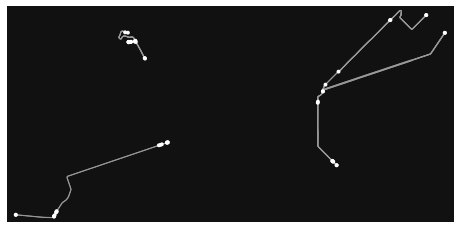

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
tram_graph = ox.graph_from_place(place_name,
                                    retain_all=True, truncate_by_edge=True,
                                    custom_filter='["railway"~"tram"]')
ox.plot_graph(tram_graph)

In [81]:
len(tram_graph.nodes)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


48

In [82]:
nodes, edges = ox.graph_to_gdfs(tram_graph)

### Prepare POI (stops)

In [83]:
tram_stop = ox.geometries_from_place(place_name, tags={'railway':['tram_stop']})
tram_stop = tram_stop.dropna(axis=1, how='any') 
tram_stop = tram_stop.to_crs(epsg=4326)
tram_stop['lon'] = tram_stop['geometry'].apply(lambda p: p.x)
tram_stop['lat'] = tram_stop['geometry'].apply(lambda p: p.y)
tram_stop['key'] = tram_stop.index  # set a primary key column
tram_stop

,unique_id,osmid,element_type,name,public_transport,railway,tram,geometry,lon,lat,key
0,node/1483785546,1483785546,node,Lluís Muntades,stop_position,tram_stop,yes,POINT (2.13072 41.41537),2.130725,41.415366,0
1,node/1483785586,1483785586,node,Font del Racó,stop_position,tram_stop,yes,POINT (2.12964 41.41564),2.129638,41.415636,1
2,node/1483785644,1483785644,node,Plaça Dr. Andreu,stop_position,tram_stop,yes,POINT (2.13189 41.41609),2.131888,41.416093,2
3,node/1483785647,1483785647,node,Román Macaya,stop_position,tram_stop,yes,POINT (2.13492 41.41318),2.134917,41.413182,3
4,node/1483785670,1483785670,node,Josep Garí,stop_position,tram_stop,yes,POINT (2.13342 41.41510),2.133417,41.415101,4
...,...,...,...,...,...,...,...,...,...,...,...
56,node/3395374206,3395374206,node,Palau Reial,stop_position,tram_stop,yes,POINT (2.11847 41.38594),2.118468,41.385942,56
57,node/3395374207,3395374207,node,Pius XII,stop_position,tram_stop,yes,POINT (2.12161 41.38671),2.121615,41.386707,57
58,node/3395374208,3395374208,node,Pius XII,stop_position,tram_stop,yes,POINT (2.12160 41.38673),2.121604,41.386734,58
59,node/3395374211,3395374211,node,Zona Universitària,stop_position,tram_stop,yes,POINT (2.11441 41.38426),2.114413,41.384263,59


Makes sure that the stations are not repeated 

In [84]:
tram_stop = tram_stop.drop_duplicates(subset='name', keep='first')

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
tram_stop

,unique_id,osmid,element_type,name,public_transport,railway,tram,geometry,lon,lat,key
0,node/1483785546,1483785546,node,Lluís Muntades,stop_position,tram_stop,yes,POINT (2.13072 41.41537),2.130725,41.415366,0
1,node/1483785586,1483785586,node,Font del Racó,stop_position,tram_stop,yes,POINT (2.12964 41.41564),2.129638,41.415636,1
2,node/1483785644,1483785644,node,Plaça Dr. Andreu,stop_position,tram_stop,yes,POINT (2.13189 41.41609),2.131888,41.416093,2
3,node/1483785647,1483785647,node,Román Macaya,stop_position,tram_stop,yes,POINT (2.13492 41.41318),2.134917,41.413182,3
4,node/1483785670,1483785670,node,Josep Garí,stop_position,tram_stop,yes,POINT (2.13342 41.41510),2.133417,41.415101,4
5,node/1483785677,1483785677,node,Plaça Kennedy,stop_position,tram_stop,yes,POINT (2.13685 41.41047),2.136849,41.410467,5
6,node/1747487695,1747487695,node,Adrià Margarit,stop_position,tram_stop,yes,POINT (2.13183 41.41516),2.131830,41.415159,6
7,node/1747487697,1747487697,node,Carrer num. 15,stop_position,tram_stop,yes,POINT (2.12941 41.41535),2.129410,41.415354,7
8,node/1747487698,1747487698,node,Josep Mª Florensa,stop_position,tram_stop,yes,POINT (2.13525 41.41265),2.135251,41.412654,8
9,node/3394604126,3394604126,node,Alfons el Magnànim,stop_position,tram_stop,yes,POINT (2.21354 41.41717),2.213545,41.417170,9


### Join POI to network

In [86]:
# it's a one-liner, but is still at beta at the moment
new_nodes, new_edges = connect_poi(tram_stop, nodes, edges, key_col='key')

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 0/35 (0.00%)
NOTE: duplication in node coordinates keys
Nodes count: 118
Node coordinates key count: 80
Missing 'from' nodes: 0
Missing 'to' nodes: 0


In [87]:
real_stations = new_nodes.loc[new_nodes['highway']=='projected_pap']

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
tram_graph_new = ox.graph_from_gdfs(real_stations, edges)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


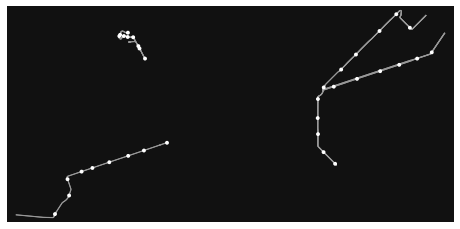

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [107]:
ox.plot_graph(tram_graph_new)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

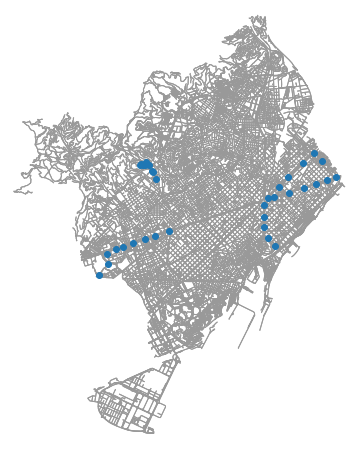

In [57]:
fig, ax1 = plt.subplots(figsize=(8,8))
ox.plot_graph(ox.project_graph(G_walk), ax = ax1, figsize = fig, node_size = 0,show=False, close=False)
ox.project_gdf(real_stations).plot(ax = ax1, figsize = fig)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


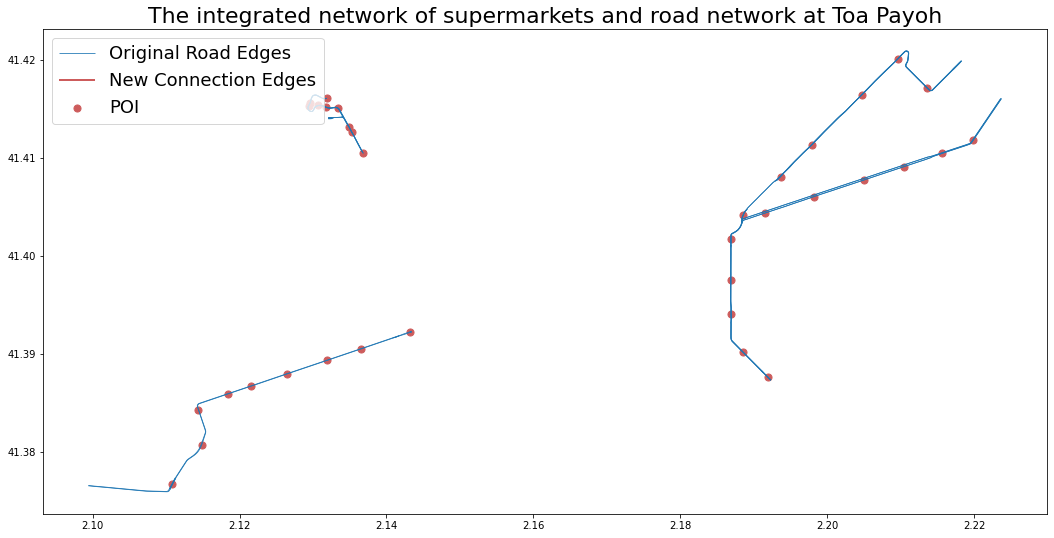

In [95]:
# output
poi_links = new_edges[new_edges['highway'] == 'projected_footway']
ax = edges.plot(linewidth=0.8, figsize=(18,10), label='Original Road Edges')
poi_links.plot(color='indianred', linewidth=2, ax=ax, label='New Connection Edges')
tram_stop.plot(color='indianred', marker='.', markersize=200, ax=ax, label='POI')
ax.legend(loc=2, fontsize=18)
ax.set_title('The integrated network of supermarkets and road network at Toa Payoh', fontsize=22);

## Subway

### Prepare Network
Get the graph from OSM. Convert to geopandas in order to obtain nodes and edges. 

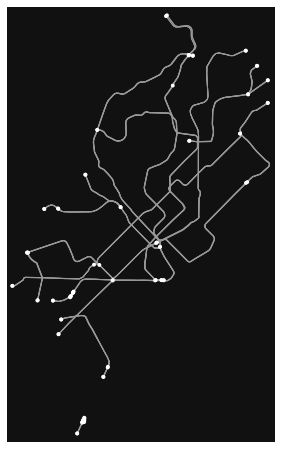

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [61]:
subway_graph = ox.graph_from_place(place_name,
                                    retain_all=True, truncate_by_edge=True,
                                    custom_filter='["railway"~"subway"]')
ox.plot_graph(subway_graph)

In [64]:
len(subway_graph.nodes)

103

In [65]:
nodes, edges = ox.graph_to_gdfs(subway_graph)

### Prepare POI (stops)

In [66]:
subway_stop = ox.geometries_from_place(place_name, tags={'railway':['subway_entrance']})
subway_stop = subway_stop.dropna(axis=1, how='any') 
subway_stop = subway_stop.to_crs(epsg=4326)
subway_stop['lon'] = subway_stop['geometry'].apply(lambda p: p.x)
subway_stop['lat'] = subway_stop['geometry'].apply(lambda p: p.y)
subway_stop['key'] = subway_stop.index  # set a primary key column
subway_stop

,unique_id,osmid,element_type,railway,geometry,lon,lat,key
0,node/26636720,26636720,node,subway_entrance,POINT (2.13590 41.38165),2.135896,41.381654,0
1,node/71709847,71709847,node,subway_entrance,POINT (2.17572 41.40387),2.175724,41.403872,1
2,node/191784425,191784425,node,subway_entrance,POINT (2.13564 41.38210),2.135635,41.382098,2
3,node/191785584,191785584,node,subway_entrance,POINT (2.14168 41.38093),2.141684,41.380926,3
4,node/191786230,191786230,node,subway_entrance,POINT (2.14016 41.38241),2.140159,41.382409,4
...,...,...,...,...,...,...,...,...
279,node/7110703705,7110703705,node,subway_entrance,POINT (2.11848 41.39856),2.118478,41.398555,279
280,node/7110703708,7110703708,node,subway_entrance,POINT (2.11932 41.39908),2.119322,41.399081,280
281,node/7546139439,7546139439,node,subway_entrance,POINT (2.16681 41.43039),2.166807,41.430388,281
282,node/7546139440,7546139440,node,subway_entrance,POINT (2.16713 41.43056),2.167127,41.430556,282


Makes sure that the stations are not repeated 

In [42]:
# subway = tram_stop.drop_duplicates(subset='name', keep='first')

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Join POI to network

In [68]:
# it's a one-liner, but is still at beta at the moment
new_nodes, new_edges = connect_poi(subway_stop, nodes, edges, key_col='key')

Building rtree...
Updating external nodes...
Projecting POIs to the network...
Updating internal nodes...
Updating internal edges...
Updating external links...
Remove faulty projections: 4/284 (1.41%)
NOTE: duplication in node coordinates keys
Nodes count: 671
Node coordinates key count: 668
Missing 'from' nodes: 0
Missing 'to' nodes: 0


In [70]:
real_stations = new_nodes.loc[new_nodes['highway']=='projected_pap']

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [80]:
edges

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,osmid,tunnel,name,oneway,length,ref,geometry,service,bridge,u,v,key
0,"[23951944, 363164181, 363164183, 363164185, 36...",yes,L7,False,1882.684,L7,"LINESTRING (2.15262 41.39921, 2.15228 41.39953...",NaN,NaN,255406865,259650085,0
1,"[363193568, 363322617, 549538222, 38915350, 36...",yes,"[L12, S1;S2;S5;S55;L6, S1-S2-S5-S55 Metro del ...",False,2543.467,"[L12, S1;S2;S5;S55;L6]","LINESTRING (2.15262 41.39921, 2.15241 41.39939...",NaN,NaN,255406865,3610341996,0
2,"[363139235, 810841350, 544215271, 544215272, 5...",yes,S1-S2-S5-S55 Metro del Vallès;L6-L7 Metro de B...,False,2200.601,NaN,"LINESTRING (2.15262 41.39921, 2.15270 41.39915...",NaN,NaN,255406865,5307617025,0
3,"[23951944, 363164181, 363164183, 363164185, 36...",yes,L7,False,1882.684,L7,"LINESTRING (2.13708 41.40996, 2.13859 41.40706...",NaN,NaN,259650085,255406865,0
4,"[810841344, 812545729, 810841346, 812545732, 5...",yes,L1,False,13415.047,L1,"LINESTRING (2.20787 41.45100, 2.20670 41.45083...",NaN,NaN,429581019,7589389939,0
...,...,...,...,...,...,...,...,...,...,...,...,...
173,812545726,yes,NaN,False,31.441,NaN,"LINESTRING (2.13186 41.37127, 2.13169 41.37102)",crossover,NaN,7589389946,7589389939,0
174,"[812545728, 332591361, 812545731]",yes,L1,False,900.753,L1,"LINESTRING (2.13186 41.37127, 2.13148 41.37085...",NaN,NaN,7589389946,5306334136,0
175,"[810841345, 812545731, 812545733, 810841352, 8...",yes,L1,False,3799.647,L1,"LINESTRING (2.13186 41.37127, 2.13226 41.37169...",NaN,NaN,7589389946,6507217425,0
176,"[550291340, 550291342, 550291345, 550291346, 5...",yes,L5,False,14768.116,L5,"LINESTRING (2.14229 41.42477, 2.14239 41.42477...",NaN,NaN,7778850859,3398928445,0


In [71]:
subway_graph_new = ox.graph_from_gdfs(real_stations, new_edges)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


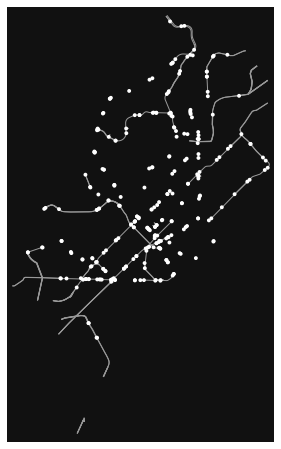

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [72]:
ox.plot_graph(subway_graph_new)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

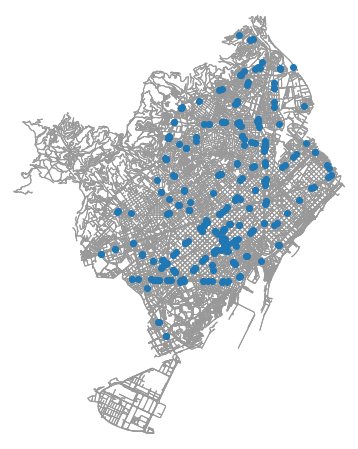

In [73]:
fig, ax1 = plt.subplots(figsize=(8,8))
ox.plot_graph(ox.project_graph(G_walk), ax = ax1, figsize = fig, node_size = 0,show=False, close=False)
ox.project_gdf(real_stations).plot(ax = ax1, figsize = fig)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

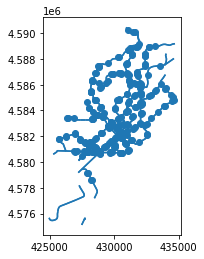

In [25]:
subway = ox.geometries_from_place(place_name, tags={'railway':['subway','subway_entrance']})
subway_proj = ox.project_gdf(subway)
subway_proj.plot()

In [1]:
G_walk = ox.graph_from_place('Barcelona, Spain', network_type = 'walk', retain_all = True)
fig, ax = ox.plot_graph(G_walk)

NameError: name 'ox' is not defined

<AxesSubplot:>

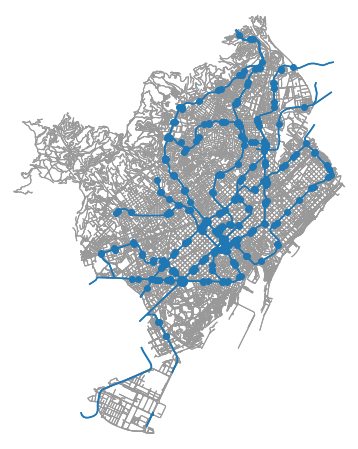

In [30]:
fig, ax1 = plt.subplots(figsize=(8,8))
ox.plot_graph(ox.project_graph(G_walk), ax = ax1, figsize = fig, node_size = 0,show=False, close=False)
subway_proj.plot(ax = ax1, figsize = fig)

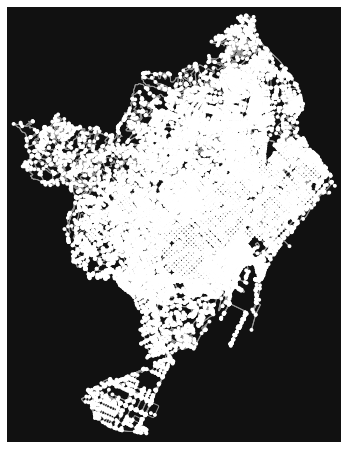

In [59]:
G_bike = ox.graph_from_place('Barcelona, Spain', network_type = 'bike')
fig, ax = ox.plot_graph(G_bike)

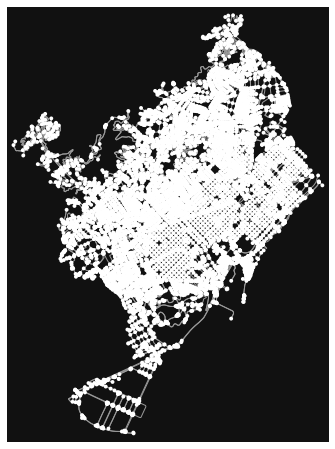

In [3]:
G_drive = ox.graph_from_place('Barcelona, Spain', network_type = 'drive')
fig, ax = ox.plot_graph(G_drive)

In [155]:
nodes_proj, edges_proj = ox.graph_to_gdfs(ox.project_graph(G_drive), nodes=True, edges=True)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [156]:
nodes_proj.head(5)

,y,x,osmid,lon,lat,highway,ref,geometry
21638845,4.580161e+06,432072.467586,21638845,2.187758,41.370095,NaN,NaN,POINT (432072.468 4580160.618)
21638855,4.580702e+06,432167.222832,21638855,2.188831,41.374983,NaN,NaN,POINT (432167.223 4580702.446)
21638859,4.580854e+06,432157.167324,21638859,2.188693,41.376347,NaN,NaN,POINT (432157.167 4580854.015)
21638861,4.581039e+06,432104.276397,21638861,2.188040,41.378011,NaN,NaN,POINT (432104.276 4581039.328)
21638865,4.580900e+06,432319.661134,21638865,2.190631,41.376773,NaN,NaN,POINT (432319.661 4580899.827)


In [159]:
nodes_proj.loc[nodes_proj['osmid'] == 21638861]['lat'].item()

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


41.3780115

In [56]:
edges_proj[edges_proj['index'] == 2]['geometry'].item().xy

(array('d', [2.1877583, 2.1877006, 2.1876541, 2.1876269, 2.1875931, 2.1876124, 2.1876664, 2.1877969, 2.1879222, 2.1879268, 2.1879373, 2.1879812, 2.188041, 2.1881072, 2.1881591, 2.188195, 2.1883635, 2.1884591, 2.1886058, 2.1886594, 2.1887166, 2.1887771, 2.1888306]),
 array('d', [41.3700945, 41.3701819, 41.3702517, 41.3702846, 41.3703647, 41.3705394, 41.3708748, 41.3716845, 41.3724622, 41.372491, 41.3725507, 41.3728904, 41.3733653, 41.3736028, 41.3737165, 41.3737952, 41.3741086, 41.3742718, 41.3745392, 41.3746409, 41.3747483, 41.3748643, 41.3749826]))

In [78]:
G = ox.graph_from_place('Barcelona, Spain',
                        retain_all=True, truncate_by_edge=True,custom_filter='["route"~"subway"]')

EmptyOverpassResponse: There are no data elements in the response JSON

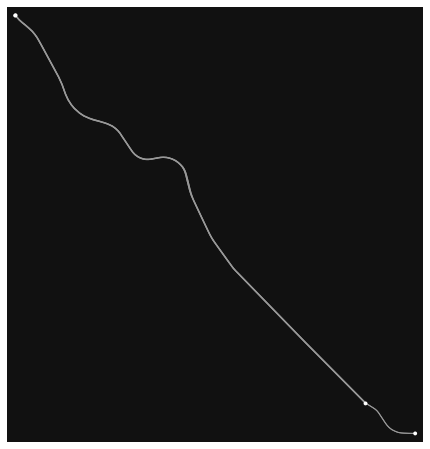

In [76]:
fig, ax = ox.plot_graph(G)

/Users/eudald/UNI/TFG/iperEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

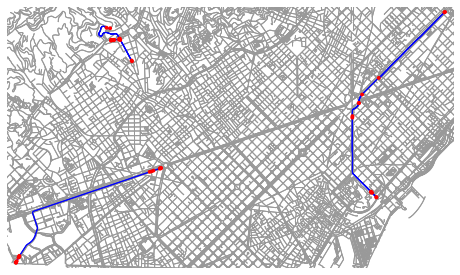

In [138]:
fig, ax1 = plt.subplots(figsize=(8,8))
ox.plot_graph(G_walk, ax = ax1, figsize = fig, node_size = 0,show=False, close=False)
ox.plot_graph(G_tram, ax = ax1, figsize = fig, node_color = 'red', edge_color = 'blue',show=False, close=False)


In [96]:
nodes, edges = ox.graph_to_gdfs(G)
nodes

,y,x,osmid,ref,geometry
255406865,41.399209,2.152623,255406865,NaN,POINT (2.15262 41.39921)
259650085,41.409960,2.137076,259650085,NaN,POINT (2.13708 41.40996)
429581019,41.451000,2.207874,429581019,NaN,POINT (2.20787 41.45100)
462259774,41.449529,2.182759,462259774,NaN,POINT (2.18276 41.44953)
462259778,41.462751,2.173055,462259778,NaN,POINT (2.17306 41.46275)
...,...,...,...,...,...
7589389939,41.371019,2.131688,7589389939,NaN,POINT (2.13169 41.37102)
7589389940,41.370965,2.131638,7589389940,NaN,POINT (2.13164 41.37097)
7589389946,41.371270,2.131862,7589389946,NaN,POINT (2.13186 41.37127)
7778850859,41.424766,2.142286,7778850859,NaN,POINT (2.14229 41.42477)


In [5]:
G_drive_proj = ox.project_graph(G_drive)

In [5]:
# what sized area does our network cover in square meters?
nodes_proj = ox.graph_to_gdfs(G_drive_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

117484164.84254007

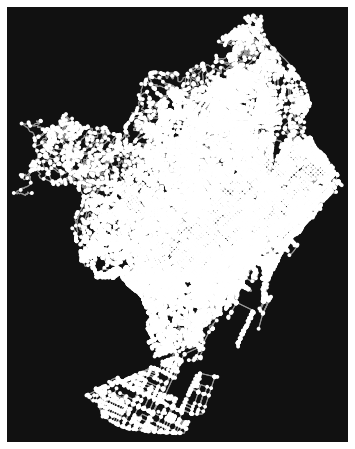

In [6]:
G_walk = ox.graph_from_place('Barcelona, Spain', network_type = 'walk')

fig, ax = ox.plot_graph(G_walk)

### Show some basic stats about the network

In [8]:
ox.basic_stats(G_drive_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'n': 8810,
 'm': 16644,
 'k_avg': 3.778433598183882,
 'intersection_count': 8167,
 'streets_per_node_avg': 3.163450624290579,
 'streets_per_node_counts': {0: 0,
  1: 643,
  2: 115,
  3: 5312,
  4: 2651,
  5: 77,
  6: 12},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.07298524404086265,
  2: 0.013053348467650397,
  3: 0.6029511918274688,
  4: 0.30090805902383655,
  5: 0.008740068104426789,
  6: 0.001362088535754824},
 'edge_length_total': 1689953.1689999963,
 'edge_length_avg': 101.53527811824058,
 'street_length_total': 1382571.508999994,
 'street_length_avg': 99.7526341269837,
 'street_segments_count': 13860,
 'node_density_km': 74.98882944614482,
 'intersection_density_km': 69.51575142867931,
 'edge_density_km': 14384.518724416874,
 'street_density_km': 11768.151996083952,
 'circuity_avg': 1.0627893695110502,
 'self_loop_proportion': 0.0009613073780341264,
 'clean_intersection_count': 5856,
 'clean_intersection_density_km': 49.8450153503546}

In [12]:
def get_basic_stats(stats = None):
        basic_stats = ox.basic_stats(G_drive_proj, area=117484164.84254007, clean_intersects=True, tolerance=15, circuity_dist='euclidean')
        if stats == None: 
            return basic_stats
        else:
            desired_stats = {}
            for stat in stats:
                desired_stats[stat] = basic_stats[stat]
            return desired_stats

In [13]:
stats = ['intersection_count', 'streets_per_node_counts']
get_basic_stats(stats)

{'intersection_count': 8167,
 'streets_per_node_counts': {0: 0,
  1: 643,
  2: 115,
  3: 5312,
  4: 2651,
  5: 77,
  6: 12}}

In [10]:
for key in sorted(stats.keys()):
    print(key)

circuity_avg
clean_intersection_count
clean_intersection_density_km
edge_density_km
edge_length_avg
edge_length_total
intersection_count
intersection_density_km
k_avg
m
n
node_density_km
self_loop_proportion
street_density_km
street_length_avg
street_length_total
street_segments_count
streets_per_node_avg
streets_per_node_counts
streets_per_node_proportion


In [56]:
extended_stats = ox.extended_stats(G_drive_proj)
extended_stats

{'avg_neighbor_degree': {21638845: 2.0,
  21638855: 2.0,
  21638859: 1.0,
  21638861: 2.0,
  21638865: 2.0,
  21638867: 2.6666666666666665,
  21638868: 2.0,
  21638869: 2.6666666666666665,
  21638877: 1.5,
  21638878: 1.5,
  21638882: 1.5,
  21638889: 1.5,
  21638891: 2.5,
  21638917: 2.5,
  21638920: 2.0,
  21638921: 1.0,
  21638922: 2.0,
  21639537: 2.6666666666666665,
  26057050: 1.5,
  26057051: 2.0,
  26057074: 1.0,
  26057076: 1.5,
  26057079: 2.0,
  26057116: 1.5,
  26057125: 2.0,
  26057131: 1.5,
  26057304: 2.0,
  26057312: 1.5,
  26057341: 2.0,
  26057342: 1.5,
  26057345: 2.0,
  26057346: 1.0,
  26057347: 1.5,
  26057388: 2.0,
  26057389: 2.0,
  26198823: 2.0,
  26198828: 2.0,
  26198831: 2.0,
  26198833: 2.0,
  26198844: 2.0,
  30227025: 0.5,
  30227027: 0.0,
  30227032: 2.0,
  30227034: 1.0,
  30227035: 1.0,
  30227037: 0.0,
  30227050: 1.0,
  30227052: 1.0,
  30227068: 2.3333333333333335,
  30227070: 1.0,
  30227084: 2.0,
  30227134: 3.0,
  30227135: 2.0,
  30227136: 1.75

In [21]:
area = ox.geocode('Madrid, Spain')
area

(40.4167047, -3.7035825)

# Complex Intersection Consolidation

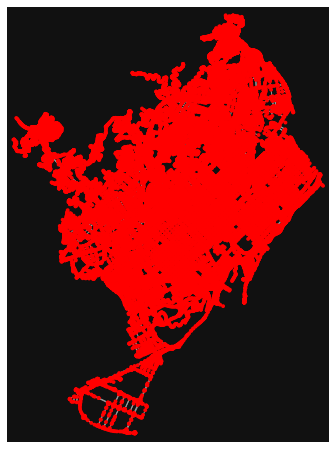

In [12]:
G_drive_complex = ox.graph_from_place('Barcelona, Spain', network_type = 'drive',simplify = False)
fig, ax = ox.plot_graph(G_drive_complex, node_color= 'r')

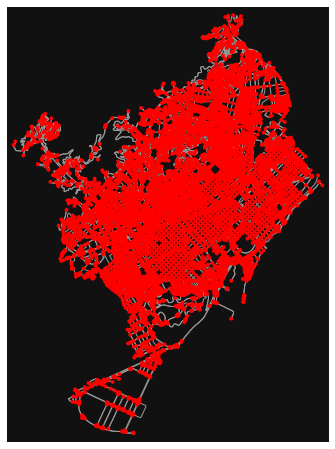

In [13]:
fig, ax = ox.plot_graph(G_drive, node_color = 'r')

In [14]:
# Consolidate intersections which have more than one node with in 15 m
intersections = ox.consolidate_intersections(G_drive_proj, rebuild_graph=False, tolerance=15, dead_ends=False)

In [15]:
print(len(intersections))
print(len(G_drive))

5856
8810


In [17]:
# To apply that into our graph we must set the variable rebuild_graph to True
G_drive_simplified = ox.consolidate_intersections(G_drive_proj, rebuild_graph=True, tolerance=15, dead_ends=False)
len(G_drive_simplified)

5960

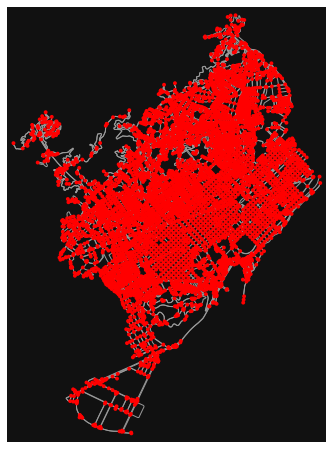

In [18]:
fig, ax = ox.plot_graph(G_drive_simplified, node_color='r')

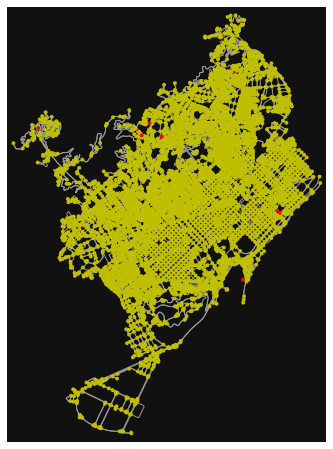

In [21]:
# plot the simplified network and highlight any self-loop edges
loops = [edge[0] for edge in nx.selfloop_edges(G_drive_simplified)]
nc = ['r' if node in loops else 'y' for node in G_drive_simplified.nodes()]
fig, ax = ox.plot_graph(G_drive_simplified, node_color=nc)

# Load times

In [41]:
G = ox.graph_from_place('Barcelona, Spain', network_type = 'walk', clean_periphery = True)

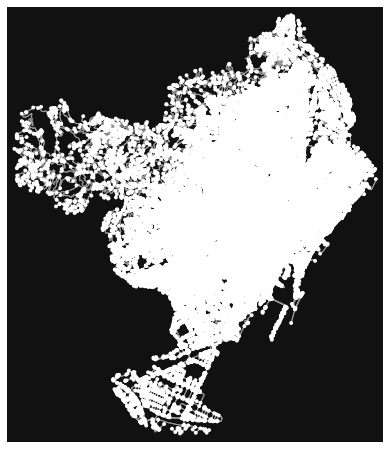

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [47]:
ox.plot_graph(G)

In [43]:
G_nobuffer = ox.graph_from_place('Barcelona, Spain', network_type = 'drive')

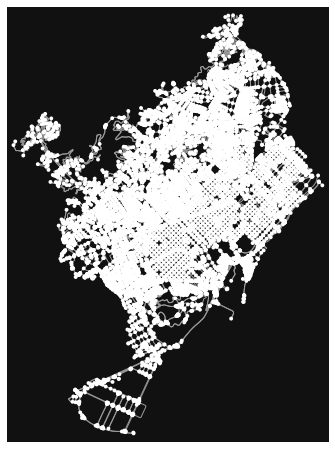

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [49]:
ox.plot_graph(G_nobuffer)

In [44]:
G_drive = ox.graph_from_place('Barcelona, Spain', network_type = 'drive', buffer_dist = 500)

In [42]:
import timeit

start = timeit.default_timer()

G_proj = ox.project_graph(G)
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
        
stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  44.071047806000024


In [45]:
start = timeit.default_timer()

G_proj = ox.project_graph(G_drive)
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
        
stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  5.529392567999821


In [46]:
start = timeit.default_timer()

G_proj = ox.project_graph(G_nobufferfer)
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj, nodes=True, edges=True)
        
stop = timeit.default_timer()

print('Time: ', stop - start)

Time:  3.490000169000268


In [39]:
G_zoom_drive.nodes[26057116]

{'y': 41.3857494, 'x': 2.1701343, 'osmid': 26057116}

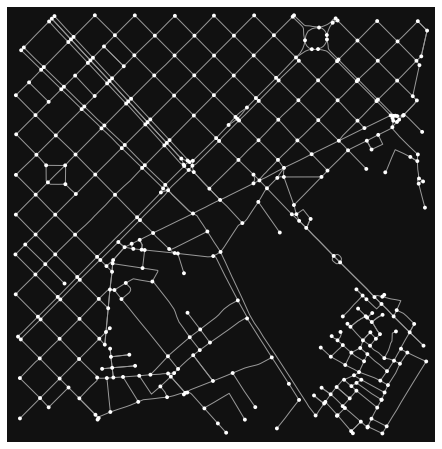

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
G_zoom_drive = ox.graph_from_address('Plaça Catalunya, Barcelona, Spain', dist = 1000, network_type = 'drive')
ox.plot_graph(G_zoom_drive)

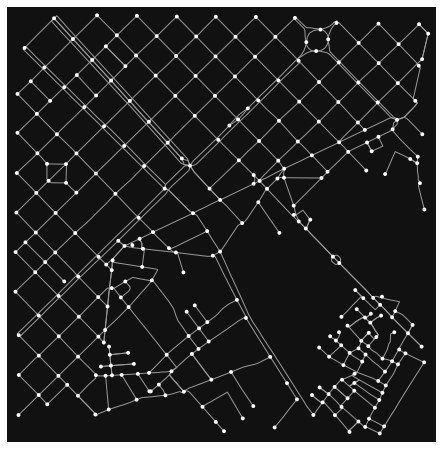

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [51]:
# Simplify the graph
G_zoom_drive_simp = ox.consolidate_intersections(ox.project_graph(G_zoom_drive), rebuild_graph=True, tolerance=15, dead_ends=True)
ox.plot_graph(G_zoom_drive_simp)

In [174]:
intersections = ox.consolidate_intersections(ox.project_graph(G_zoom_drive), rebuild_graph=False, tolerance=15, dead_ends=False)
intersectionsº

0      POINT (431378.121 4581043.835)
1      POINT (431229.287 4581056.005)
2      POINT (431398.827 4581077.447)
3      POINT (429651.768 4581131.701)
4      POINT (431163.702 4581130.833)
                    ...              
271    POINT (430609.959 4582160.248)
272    POINT (429737.032 4582192.964)
273    POINT (430115.108 4582188.808)
274    POINT (429928.422 4582194.209)
275    POINT (430349.249 4582212.443)
Length: 276, dtype: geometry

In [63]:
nodes_proj, edges_proj = ox.graph_to_gdfs(G_zoom_drive, nodes=True, edges=True)

In [80]:
nodes_proj.loc[26057116]

y                                41.3857
x                                2.17013
osmid                           26057116
highway                              NaN
geometry    POINT (2.1701343 41.3857494)
Name: 26057116, dtype: object

# Routing 

## Fast nearest node/ edge search

In [36]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(ox.project_graph(G_drive), nodes = True )

In [40]:
gdf_nodes.head()

,y,x,osmid,lon,lat,highway,ref,geometry
21638845,4.580161e+06,432072.467586,21638845,2.187758,41.370095,NaN,NaN,POINT (432072.468 4580160.618)
21638855,4.580702e+06,432167.222832,21638855,2.188831,41.374983,NaN,NaN,POINT (432167.223 4580702.446)
21638859,4.580854e+06,432157.167324,21638859,2.188693,41.376347,NaN,NaN,POINT (432157.167 4580854.015)
21638861,4.581039e+06,432104.276397,21638861,2.188040,41.378011,NaN,NaN,POINT (432104.276 4581039.328)
21638865,4.580900e+06,432319.661134,21638865,2.190631,41.376773,NaN,NaN,POINT (432319.661 4580899.827)


In [68]:
maxx = gdf_nodes['x'].max()
maxx

435145.80844093754

In [52]:
# Retrieve the node that is the most eastern one and get the Shapely Point geometry out of it
target = gdf_nodes.loc[gdf_nodes['x']==maxx, 'lon'].values[0]
print(target)

2.2240543


In [184]:
#convert the projected graph to edges goedataframe
gdf_edges = ox.graph_to_gdfs(ox.project_graph(G_zoom_drive), nodes = False )

# list of lats and lngs
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])

# the lat, lng at the spatial center of the graph
lng, lat = gdf_edges.unary_union.centroid.coords[0]
center_point = lat, lng

In [185]:
# find the nearest node to some point
point = center_point
node = ox.get_nearest_node(ox.project_graph(G_zoom_drive), point)
node

1374636407

In [186]:
# find the nearest nodes to a set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_nodes = ox.get_nearest_nodes(ox.project_graph(G_zoom_drive), lngs, lats, method='kdtree')
nearest_nodes

array([216350784,  26057116,  26057304,  30254228,  26057131])

In [187]:
# find the nearest edge to some point
nearest_edge = ox.get_nearest_edge(ox.project_graph(G_zoom_drive), center_point)
print(nearest_edge)

(1362900007, 26057125, 0)


In [188]:
# find the nearest edges to some set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_edges = ox.get_nearest_edges(ox.project_graph(G_zoom_drive), lngs, lats)
nearest_edges

array([[  26057116,  216350784,          0],
       [  26057116, 1126640615,          0],
       [  26057125,   26057304,          0],
       [  26057131,   30254228,          0],
       [  26057131, 5001160871,          0]])

## Basic routing by distance

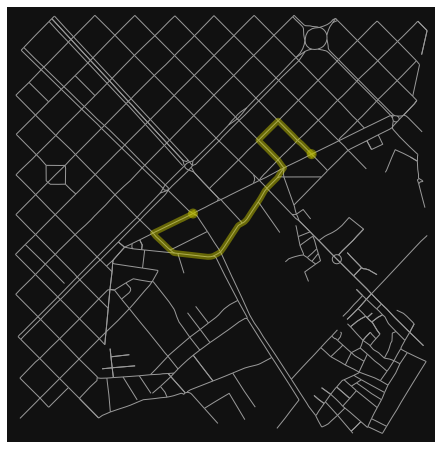

In [220]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G_zoom_drive)[1]
dest = list(G_zoom_drive)[6]
#origin = (intersections[0].centroid.x,intersections[0].centroid.y)
#destination = (intersections[274].centroid.x,intersections[274].centroid.y)
#origin_node = ox.get_nearest_node(G_zoom_drive, origin)
#destination_node = ox.get_nearest_node(G_zoom_drive, destination)

route = ox.shortest_path(G_zoom_drive, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G_zoom_drive, route, route_color='y', route_linewidth=6, node_size=0)

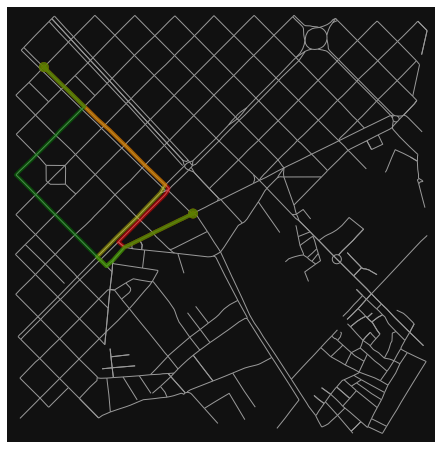

In [191]:
routes = ox.k_shortest_paths(G_zoom_drive, orig, dest, k=3, weight='length') # number of shortest paths
fig, ax = ox.plot_graph_routes(G_zoom_drive, list(routes), route_colors=['r','y','g'], route_linewidth=4, node_size=0)


## Imputing travel speeds and times

In [193]:
# Since we dont have spped limits predetermined we use hwy_speed dict
hwy_speeds = {'residential': 35,
              'living_street': 20,
              'secondary': 50,
              'tertiary': 60}
G_zoom_drive = ox.add_edge_speeds(G_zoom_drive, hwy_speeds)

In [194]:
# calculate edge travel times
G_zoom_drive = ox.add_edge_travel_times(G_zoom_drive)

In [196]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G_zoom_drive, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['living_street', 'residential']",113.9,27.5,14.8
"['living_street', 'tertiary']",136.1,25.0,19.6
"['secondary', 'tertiary']",63.6,40.0,5.7
living_street,125.2,18.3,29.6
primary,82.8,50.0,6.0
primary_link,127.8,42.9,11.5
residential,88.9,30.1,10.7
secondary,93.1,50.0,6.7
secondary_link,54.0,50.0,3.9


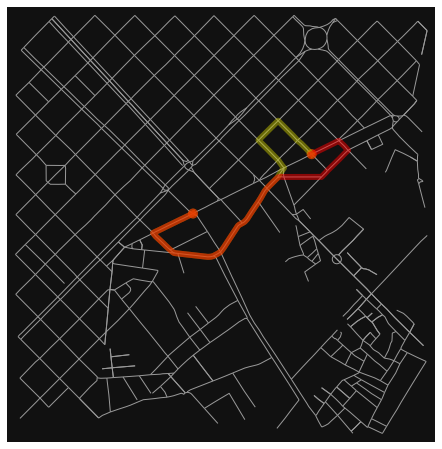

In [210]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G_zoom_drive)[1]
dest = list(G_zoom_drive)[6]
route1 = ox.shortest_path(G_zoom_drive, orig, dest, weight='length')
route2 = ox.shortest_path(G_zoom_drive, orig, dest, weight='travel_time')

# plot the routes
fig, ax = ox.plot_graph_routes(G_zoom_drive, routes=[route1, route2], route_colors=['y', 'r'],
                               route_linewidth=6, node_size=0)

Compare the two routes 

In [212]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_zoom_drive, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G_zoom_drive, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_zoom_drive, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G_zoom_drive, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

Route 1 is 1617 meters and takes 131 seconds.
Route 2 is 1621 meters and takes 119 seconds.


### Route from coordinates 

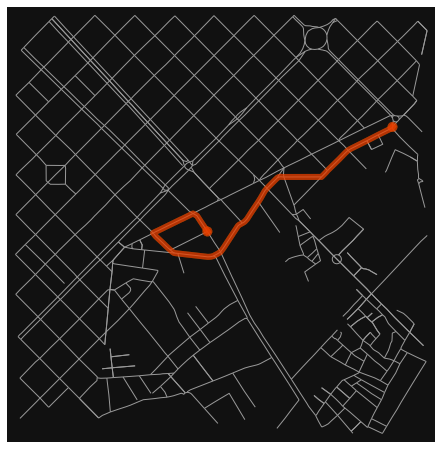

In [214]:
origin = (41.387026, 2.170115)
destination = (41.391055, 2.180111)
origin_node = ox.get_nearest_node(G_zoom_drive, origin)
destination_node = ox.get_nearest_node(G_zoom_drive, destination)
route1 = ox.shortest_path(G_zoom_drive, origin_node, destination_node, weight='length')
route2 = ox.shortest_path(G_zoom_drive, origin_node, destination_node, weight='travel_time')
# plot the routes
fig, ax = ox.plot_graph_routes(G_zoom_drive, routes=[route1, route2], route_colors=['y', 'r'],
                               route_linewidth=6, node_size=0)

# Visualize street centrality

In [7]:
list(G_zoom_drive.nodes)[4]

26057312

In [11]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G_zoom_drive), )
nx.set_edge_attributes(G_zoom_drive, edge_centrality, 'edge_centrality')

NodeNotFound: Source 4 is not in G

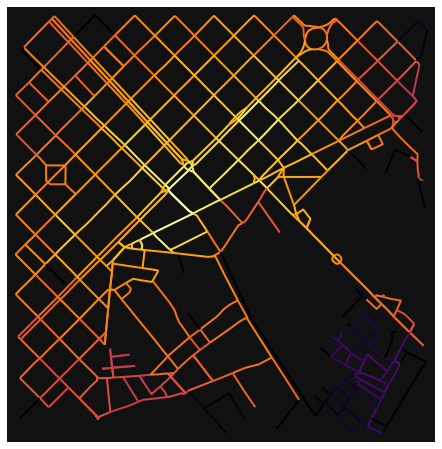

In [5]:
# color edges in original graph with closeness centralities from line graph
ec = ox.plot.get_edge_colors_by_attr(G_zoom_drive, 'edge_centrality', cmap='inferno')
fig, ax = ox.plot_graph(G_zoom_drive, edge_color=ec, edge_linewidth=2, node_size=0)